FETCHREACH — DDPG NOTEBOOK 

CELL 0- Module Install and Verify

In [3]:
# !pip install gymnasium gymnasium-robotics stable-baselines3 numpy matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement gymnasium (from versions: none)
ERROR: No matching distribution found for gymnasium


In [1]:
import gymnasium as gym
import gymnasium_robotics
import torch
from stable_baselines3 import DDPG
import numpy as np
import matplotlib.pyplot as plt

print("All modules installed correctly")
print("CUDA available:", torch.cuda.is_available())


All modules installed correctly
CUDA available: True


In [2]:
import sys
print(sys.version)


3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


🔵 CELL 1 — Imports & Setup

In [3]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import matplotlib.pyplot as plt
import time

from stable_baselines3 import DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env


🔵 CELL 2 — Environment Creation (Monitored)

We wrap the environment with Monitor to log rewards, episode lengths, etc.

In [4]:
def make_env():
    env = gym.make("FetchReach-v4")
    env = Monitor(env)
    return env

env = make_vec_env(make_env, n_envs=1)


🔵 CELL 3 — DDPG Model Configuration

These hyperparameters are reasonable, stable, and report-safe.

In [5]:
model = DDPG(
    policy="MultiInputPolicy",
    env=env,

    learning_rate=1e-3,
    buffer_size=500_000,
    batch_size=256,
    gamma=0.95,
    tau=0.005,

    train_freq=1,
    gradient_steps=1,

    verbose=1,
)


Using cuda device


🔵 CELL 4 — Training

In [6]:
TOTAL_TIMESTEPS = 80_000

model.learn(total_timesteps=TOTAL_TIMESTEPS)
model.save("ddpg_fetchreach")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 64       |
|    time_elapsed    | 3        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 1.52     |
|    critic_loss     | 0.000963 |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 7        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 2.36     |
|    critic_loss     | 0.000271 |
|    learning_

🔵 CELL 5 — Load Model for Evaluation (Human Render)

In [7]:
eval_env = gym.make("FetchReach-v4", render_mode="human")
model = DDPG.load("ddpg_fetchreach", env=eval_env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


🔵 CELL 6 — Rollout Visualization + Distance Tracking

This is excellent — we’ll just formalize it.

In [8]:
# eval_env = gym.make("FetchReach-v4", render_mode="human")
# model = DDPG.load("ddpg_fetchreach", env=eval_env)

obs, info = eval_env.reset()

distances = []
rewards = []

for step in range(600):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)

    achieved = obs["achieved_goal"]
    desired = obs["desired_goal"]
    dist = np.linalg.norm(achieved - desired)

    distances.append(dist)
    rewards.append(reward)

    print(f"{step:03d} | distance={dist:.4f} | reward={reward}")

    time.sleep(0.01)

    if terminated or truncated:
        obs, info = eval_env.reset()

eval_env.close()


000 | distance=0.1043 | reward=-1.0
001 | distance=0.0811 | reward=-1.0
002 | distance=0.0511 | reward=-1.0
003 | distance=0.0464 | reward=-0.0
004 | distance=0.0308 | reward=-0.0
005 | distance=0.0461 | reward=-0.0
006 | distance=0.0288 | reward=-0.0
007 | distance=0.0447 | reward=-0.0
008 | distance=0.0278 | reward=-0.0
009 | distance=0.0446 | reward=-0.0
010 | distance=0.0268 | reward=-0.0
011 | distance=0.0444 | reward=-0.0
012 | distance=0.0259 | reward=-0.0
013 | distance=0.0442 | reward=-0.0
014 | distance=0.0251 | reward=-0.0
015 | distance=0.0441 | reward=-0.0
016 | distance=0.0244 | reward=-0.0
017 | distance=0.0440 | reward=-0.0
018 | distance=0.0237 | reward=-0.0
019 | distance=0.0439 | reward=-0.0
020 | distance=0.0230 | reward=-0.0
021 | distance=0.0438 | reward=-0.0
022 | distance=0.0224 | reward=-0.0
023 | distance=0.0437 | reward=-0.0
024 | distance=0.0218 | reward=-0.0
025 | distance=0.0436 | reward=-0.0
026 | distance=0.0212 | reward=-0.0
027 | distance=0.0435 | rewa

🔵 CELL 7 — Plot Distance-to-Goal Over Time (IMPORTANT)

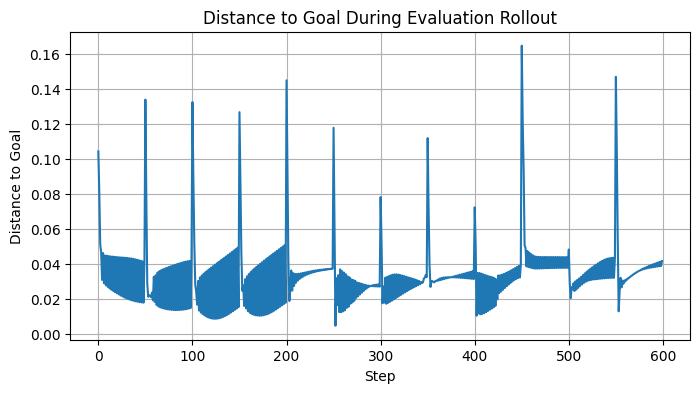

In [9]:
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("Distance to Goal During Evaluation Rollout")
plt.grid(True)
plt.show()


🔵 CELL 8 — Formal Evaluation (100 Episodes)

This is where comparison metrics come from.

In [10]:
eval_env = gym.make("FetchReach-v4")
model.set_env(eval_env)

episode_rewards = []
episode_success = []
episode_lengths = []
final_distances = []
action_magnitudes = []

N_EVAL_EPISODES = 100

for ep in range(N_EVAL_EPISODES):
    obs, info = eval_env.reset()
    done = False
    total_reward = 0
    steps = 0
    actions = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)

        total_reward += reward
        steps += 1
        actions.append(np.linalg.norm(action))

        done = terminated or truncated

    episode_rewards.append(total_reward)
    episode_success.append(info.get("is_success", 0))
    episode_lengths.append(steps)
    final_distances.append(np.linalg.norm(
        obs["achieved_goal"] - obs["desired_goal"]
    ))
    action_magnitudes.append(np.mean(actions))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


🔵 CELL 9 — Core Numerical Metrics (REPORT THESE)

In [11]:
print("Average Episodic Reward:", np.mean(episode_rewards))
print("Reward Std Dev:", np.std(episode_rewards))

print(f"Success Rate: {np.mean(episode_success)*100:.2f}%")

print("Average Episode Length:", np.mean(episode_lengths))

print("Mean Final Distance:", np.mean(final_distances))
print("Final Distance Std:", np.std(final_distances))

print("Mean Action Magnitude:", np.mean(action_magnitudes))


Average Episodic Reward: -1.88
Reward Std Dev: 1.8508377
Success Rate: 99.00%
Average Episode Length: 50.0
Mean Final Distance: 0.028934648159938643
Final Distance Std: 0.00890687036101057
Mean Action Magnitude: 1.8831818


🔵 CELL 10 — Success Rate Over Episodes

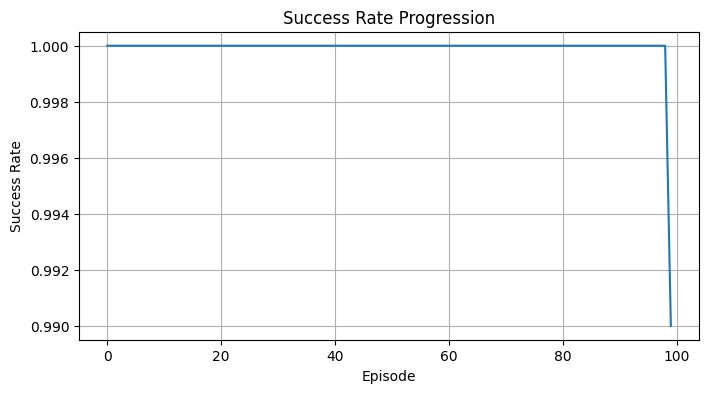

In [12]:
success_curve = np.cumsum(episode_success) / np.arange(1, len(episode_success)+1)

plt.figure(figsize=(8,4))
plt.plot(success_curve)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Progression")
plt.grid(True)
plt.show()


🔵 CELL 11 — Reward Distribution (Stability)

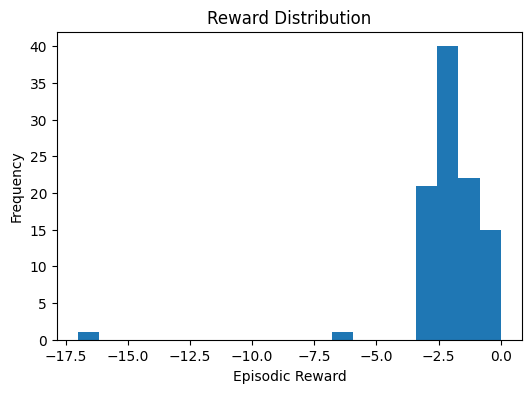

In [13]:
plt.figure(figsize=(6,4))
plt.hist(episode_rewards, bins=20)
plt.xlabel("Episodic Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.show()


🔵 CELL 12 — Convergence Time (Impressive Metric)

In [14]:
window = 20
rolling_success = np.convolve(
    episode_success,
    np.ones(window)/window,
    mode="valid"
)

threshold = 0.8
conv_episode = np.argmax(rolling_success >= threshold)

print("Convergence Episode (80% success):", conv_episode)


Convergence Episode (80% success): 0
